<a href="https://colab.research.google.com/github/samitha278/miniVGG/blob/main/build2_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import time
import math
import matplotlib.pyplot as plt

from dataclasses import dataclass

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get Data MNIST

In [2]:
batch_size = 16

In [47]:
transform_train = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform_train)
val_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform_train)


train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [4]:
image ,label  = next(iter(train_data))
image.shape

torch.Size([16, 1, 28, 28])

In [6]:
flat = nn.Flatten()

flat(image).shape

torch.Size([16, 784])

## Model Implementation

In [21]:
@dataclass
class Config():
    in_ch : int = 1
    n_embd : int = 36
    n_class : int = 10







class minVGG(nn.Module):

    def __init__(self,config):
        super().__init__()



        self.conv_1 = nn.Conv2d(config.in_ch, 2*config.in_ch,5)
        self.pooling_1 = nn.MaxPool2d(3)

        self.conv_2 = nn.Conv2d(2* config.in_ch, 4*config.in_ch,3)
        self.pooling_2 = nn.MaxPool2d(2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()

        self.mlp = MLP(config)


    def forward(self,x,targets = None):

        B,C,H,W = x.shape

        #1
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.pooling_1(x)

        #2
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.pooling_2(x)

        x = self.flatten(x)

        logits = self.mlp(x)

        loss = None
        if targets is not None:
            return logits , F.cross_entropy(logits,targets)

        return logits







class MLP(nn.Module):


    def __init__(self,config):
        super().__init__()

        self.layer = nn.Linear(config.n_embd,4*config.n_embd)
        self.relu = nn.ReLU()
        self.proj = nn.Linear(4*config.n_embd,config.n_class)


    def forward(self,x):

        x = self.layer(x)
        x = self.relu(x)
        x = self.proj(x)

        return x






In [23]:
config = Config()
cnn = minVGG(config)
cnn(image).shape

torch.Size([16, 10])

## Train

In [30]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)



max_iter = 1000
lr = 3e-4



cnn = minVGG(Config())
cnn = cnn.to(device)
cnn = torch.compile(cnn)



losses = torch.zeros((max_iter,))

use_fused = torch.cuda.is_available()
optimizer = torch.optim.AdamW(cnn.parameters(),lr = lr ,fused = use_fused)

train_iter = iter(train_data)

for i in range(max_iter):

    t0 = time.time()

    xb , yb = next(train_iter)
    xb,yb = xb.to(device) , yb.to(device)

    logits , loss = cnn(xb,yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    torch.cuda.synchronize() if torch.cuda.is_available() else None

    t1 = time.time()
    dt = (t1-t0) * 1000 # ms

    losses[i] = loss.item()

    if i%100 ==0 : print(f'{i}/{max_iter}  {loss.item()}  {dt} ms')



0/1000  2.310445547103882  10.44607162475586 ms
100/1000  2.21236515045166  6.488561630249023 ms
200/1000  1.666076898574829  6.346940994262695 ms
300/1000  1.0901288986206055  6.270408630371094 ms
400/1000  0.8322466611862183  7.765293121337891 ms
500/1000  0.7781930565834045  8.962154388427734 ms
600/1000  0.7698603868484497  8.695602416992188 ms
700/1000  0.5577788352966309  11.706829071044922 ms
800/1000  0.33924227952957153  6.481409072875977 ms
900/1000  0.7270603775978088  6.339788436889648 ms


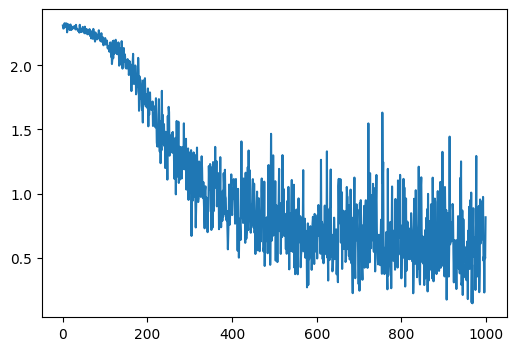

In [31]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

## Inference / Accuracy

In [37]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)



xb , yb = next(iter(val_data))

logits = cnn(xb)

probs = F.softmax(logits,dim=-1)

predictions = torch.argmax(probs,dim=-1)

acc = (predictions == yb).float().mean()

print(f"Batch accuracy: {acc.item():.4f}")

Batch accuracy: 0.6875


### Accuracy for full val_data

In [38]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

correct, total = 0, 0
for xb, yb in val_data:
    logits = cnn(xb)
    preds = torch.argmax(logits, dim=-1)
    correct += (preds == yb).sum().item()
    total += yb.size(0)

val_acc = correct / total
print(f"Validation accuracy: {val_acc:.4f}")


Validation accuracy: 0.8368


## Batch Norm and Layer Norm to Model

In [44]:
@dataclass
class Config():
    in_ch : int = 1
    n_embd : int = 36
    n_class : int = 10


class minVGG(nn.Module):

    def __init__(self,config):
        super().__init__()



        self.conv_1 = nn.Conv2d(config.in_ch, 2*config.in_ch,5)
        self.bn1 = nn.BatchNorm2d(2*config.in_ch)     # Batch Norm 1
        self.pooling_1 = nn.MaxPool2d(3)

        self.conv_2 = nn.Conv2d(2* config.in_ch, 4*config.in_ch,3)
        self.bn2 = nn.BatchNorm2d(4*config.in_ch)     # Batch Norm 2
        self.pooling_2 = nn.MaxPool2d(2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()

        self.mlp = MLP(config)


    def forward(self,x,targets = None):

        B,C,H,W = x.shape

        #1
        x = self.conv_1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pooling_1(x)

        #2
        x = self.conv_2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pooling_2(x)

        x = self.flatten(x)

        logits = self.mlp(x)

        loss = None
        if targets is not None:
            return logits , F.cross_entropy(logits,targets)

        return logits


class MLP(nn.Module):


    def __init__(self,config):
        super().__init__()

        # pre layer norm
        self.bn = nn.LayerNorm(config.n_embd)
        self.layer = nn.Linear(config.n_embd,4*config.n_embd)
        self.relu = nn.ReLU()
        self.proj = nn.Linear(4*config.n_embd,config.n_class)


    def forward(self,x):

        x = self.layer(x)
        x = self.relu(x)
        x = self.proj(x)

        return x


In [48]:
batch_size = 16

train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Train

In [49]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)



max_iter = 1000
lr = 3e-4



cnn = minVGG(Config())
cnn = cnn.to(device)
cnn = torch.compile(cnn)



losses = torch.zeros((max_iter,))

use_fused = torch.cuda.is_available()
optimizer = torch.optim.AdamW(cnn.parameters(),lr = lr ,fused = use_fused)

train_iter = iter(train_data)

for i in range(max_iter):

    t0 = time.time()

    xb , yb = next(train_iter)
    xb,yb = xb.to(device) , yb.to(device)

    logits , loss = cnn(xb,yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    torch.cuda.synchronize() if torch.cuda.is_available() else None

    t1 = time.time()
    dt = (t1-t0) * 1000 # ms

    losses[i] = loss.item()

    if i%100 ==0 : print(f'{i}/{max_iter}  {loss.item():.4f}  {dt:.4f} ms')



0/1000  2.2896  46751.3280 ms
100/1000  1.8546  12.3034 ms
200/1000  1.4791  7.5624 ms
300/1000  1.0668  8.0299 ms
400/1000  1.0519  7.8294 ms
500/1000  0.4007  7.6325 ms
600/1000  0.5868  7.9434 ms
700/1000  0.3758  9.1152 ms
800/1000  0.3501  7.6864 ms
900/1000  0.5312  7.8576 ms


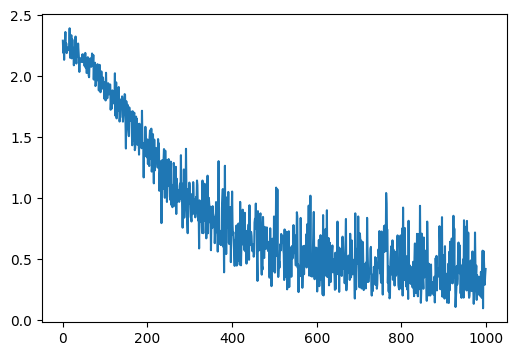

In [50]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

### Accuracy for full val_data

In [51]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

correct, total = 0, 0
for xb, yb in val_data:
    logits = cnn(xb)
    preds = torch.argmax(logits, dim=-1)
    correct += (preds == yb).sum().item()
    total += yb.size(0)

val_acc = correct / total
print(f"Validation accuracy: {val_acc:.4f}")


Validation accuracy: 0.9031


# Training techniques

- Learning rate scheduling
- Weight decay
- Gradient clipping

In [55]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)




cnn = minVGG(Config())
cnn = cnn.to(device)
cnn = torch.compile(cnn)





# ------------------------------------------------------------------------------
# Learning Rate Schedule

max_iter = 1000
max_lr = 3e-4
min_lr = max_lr * 0.01
warm_up = max_iter * 0.05


def get_lr(i):

    if i < warm_up :
        return (max_lr/warm_up) * (i+1)

    if i > max_iter :
        return min_lr

    # cosine decay
    diff = max_lr - min_lr
    steps = max_iter - warm_up
    lr = (diff/2) * math.cos(i * (math.pi / steps)) + diff
    return lr


# ------------------------------------------------------------------------------


losses = torch.zeros((max_iter,))
lrs = torch.zeros((max_iter,))
norms = torch.zeros((max_iter,))

use_fused = torch.cuda.is_available()

# optimizer with weight decay
optimizer = torch.optim.AdamW(cnn.parameters(),lr = lr ,fused = use_fused,weight_decay=0.1)

train_iter = iter(train_data)

for i in range(max_iter):

    t0 = time.time()

    xb , yb = next(train_iter)
    xb,yb = xb.to(device) , yb.to(device)

    logits , loss = cnn(xb,yb)

    optimizer.zero_grad()
    loss.backward()

    # learning rate schedule
    lr = get_lr(i)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Inplace gradient clipping
    norm = torch.nn.utils.clip_grad_norm_(cnn.parameters(),1.0)

    optimizer.step()

    torch.cuda.synchronize() if torch.cuda.is_available() else None

    t1 = time.time()
    dt = (t1-t0) * 1000 # ms

    losses[i] = loss.item()
    lrs[i] = lr
    norms[i] = norm.item()

    if i%100 ==0 : print(f'{i}/{max_iter}  {loss.item():.4f}  {dt:.4f} ms   norm:{norm.item():.4f}    lr:{lr:.4e}')



0/1000  2.2896  16.0584 ms   norm:1.5367    lr:0.0000e+00
100/1000  1.8655  8.5244 ms   norm:1.8228    lr:4.3745e-04
200/1000  1.3525  8.6081 ms   norm:2.2887    lr:4.1419e-04
300/1000  0.9474  12.7351 ms   norm:2.9101    lr:3.7822e-04
400/1000  0.9315  14.9176 ms   norm:3.4945    lr:3.3345e-04
500/1000  0.3512  9.2251 ms   norm:1.9331    lr:2.8474e-04
600/1000  0.5896  8.6942 ms   norm:2.5713    lr:2.3735e-04
700/1000  0.3812  8.8377 ms   norm:2.4289    lr:1.9642e-04
800/1000  0.3488  8.3780 ms   norm:2.8563    lr:1.6640e-04
900/1000  0.5771  8.7245 ms   norm:3.6592    lr:1.5053e-04


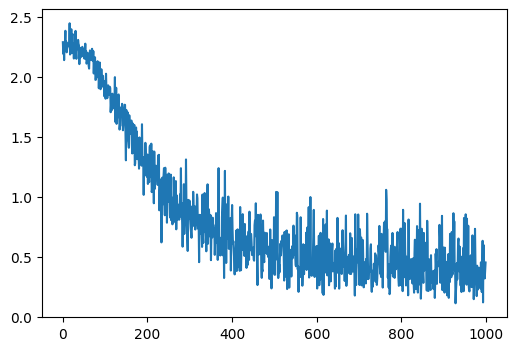

In [56]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

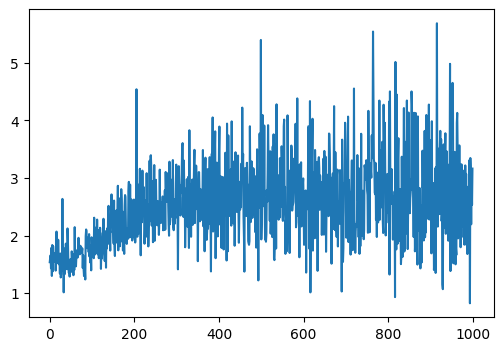

In [57]:
plt.figure(figsize=(6,4))
plt.plot(norms)
plt.show()

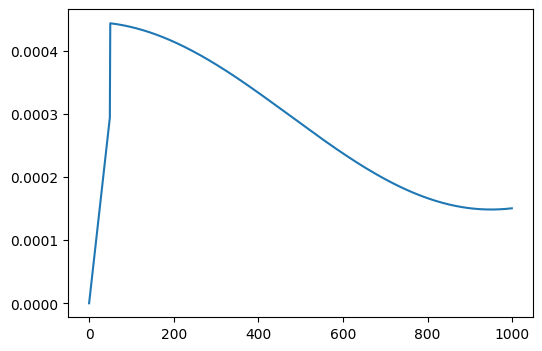

In [58]:
plt.figure(figsize=(6,4))
plt.plot(lrs)
plt.show()

### Accuracy for full val_data

In [59]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

correct, total = 0, 0
for xb, yb in val_data:
    logits = cnn(xb)
    preds = torch.argmax(logits, dim=-1)
    correct += (preds == yb).sum().item()
    total += yb.size(0)

val_acc = correct / total
print(f"Validation accuracy: {val_acc:.4f}")


Validation accuracy: 0.8947


# Add Dropout

In [60]:
@dataclass
class Config():
    in_ch : int = 1
    n_embd : int = 36
    n_class : int = 10
    dropout : int = 0.2


class minVGG(nn.Module):

    def __init__(self,config):
        super().__init__()



        self.conv_1 = nn.Conv2d(config.in_ch, 2*config.in_ch,5)
        self.bn1 = nn.BatchNorm2d(2*config.in_ch)     # Batch Norm 1
        self.pooling_1 = nn.MaxPool2d(3)

        self.conv_2 = nn.Conv2d(2* config.in_ch, 4*config.in_ch,3)
        self.bn2 = nn.BatchNorm2d(4*config.in_ch)     # Batch Norm 2
        self.pooling_2 = nn.MaxPool2d(2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()

        self.mlp = MLP(config)


    def forward(self,x,targets = None):

        B,C,H,W = x.shape

        #1
        x = self.conv_1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pooling_1(x)

        #2
        x = self.conv_2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pooling_2(x)

        x = self.flatten(x)

        logits = self.mlp(x)

        loss = None
        if targets is not None:
            return logits , F.cross_entropy(logits,targets)

        return logits


class MLP(nn.Module):


    def __init__(self,config):
        super().__init__()

        # pre layer norm
        self.bn = nn.LayerNorm(config.n_embd)
        self.layer = nn.Linear(config.n_embd,4*config.n_embd)
        self.relu = nn.ReLU()
        self.proj = nn.Linear(4*config.n_embd,config.n_class)
        self.dropout = nn.Dropout(config.dropout)


    def forward(self,x):

        x = self.layer(x)
        x = self.relu(x)
        x = self.proj(x)
        x = self.dropout(x)

        return x


## Train with dropout

In [ ]:
batch_size = 64

train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [61]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)




cnn = minVGG(Config())
cnn = cnn.to(device)
cnn = torch.compile(cnn)





# ------------------------------------------------------------------------------
# Learning Rate Schedule

max_iter = 1000
max_lr = 3e-4
min_lr = max_lr * 0.01
warm_up = max_iter * 0.05


def get_lr(i):

    if i < warm_up :
        return (max_lr/warm_up) * (i+1)

    if i > max_iter :
        return min_lr

    # cosine decay
    diff = max_lr - min_lr
    steps = max_iter - warm_up
    lr = (diff/2) * math.cos(i * (math.pi / steps)) + diff
    return lr


# ------------------------------------------------------------------------------


losses = torch.zeros((max_iter,))
lrs = torch.zeros((max_iter,))
norms = torch.zeros((max_iter,))

use_fused = torch.cuda.is_available()

# optimizer with weight decay
optimizer = torch.optim.AdamW(cnn.parameters(),lr = lr ,fused = use_fused,weight_decay=0.1)

train_iter = iter(train_data)

for i in range(max_iter):

    t0 = time.time()

    xb , yb = next(train_iter)
    xb,yb = xb.to(device) , yb.to(device)

    logits , loss = cnn(xb,yb)

    optimizer.zero_grad()
    loss.backward()

    # learning rate schedule
    lr = get_lr(i)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Inplace gradient clipping
    norm = torch.nn.utils.clip_grad_norm_(cnn.parameters(),1.0)

    optimizer.step()

    torch.cuda.synchronize() if torch.cuda.is_available() else None

    t1 = time.time()
    dt = (t1-t0) * 1000 # ms

    losses[i] = loss.item()
    lrs[i] = lr
    norms[i] = norm.item()

    if i%100 ==0 : print(f'{i}/{max_iter}  {loss.item():.4f}  {dt:.4f} ms   norm:{norm.item():.4f}    lr:{lr:.4e}')



0/1000  2.2656  19604.8870 ms   norm:1.4524    lr:6.0000e-06
100/1000  1.8833  8.2204 ms   norm:1.8657    lr:4.3745e-04
200/1000  1.5151  10.1502 ms   norm:2.1638    lr:4.1419e-04
300/1000  1.0921  8.1718 ms   norm:2.6953    lr:3.7822e-04
400/1000  1.0856  8.5363 ms   norm:3.6666    lr:3.3345e-04
500/1000  0.4387  8.5819 ms   norm:2.0355    lr:2.8474e-04
600/1000  0.6597  8.9724 ms   norm:2.2034    lr:2.3735e-04
700/1000  0.4222  8.3609 ms   norm:1.8835    lr:1.9642e-04
800/1000  0.4902  13.8175 ms   norm:3.0309    lr:1.6640e-04
900/1000  0.7900  11.1721 ms   norm:3.4189    lr:1.5053e-04


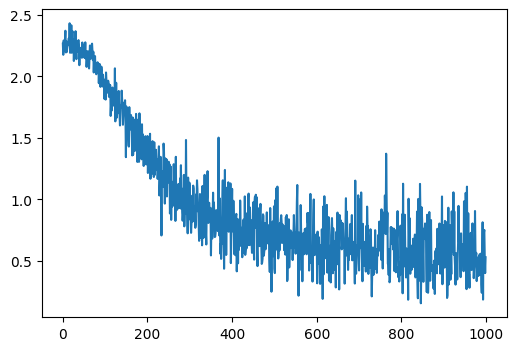

In [63]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

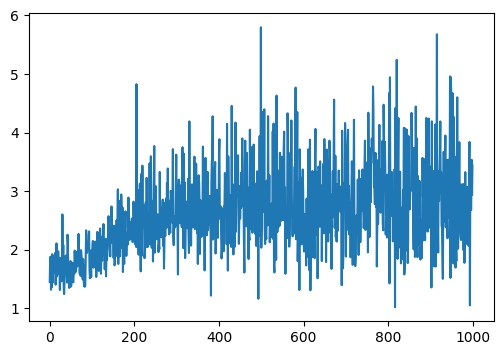

In [64]:
plt.figure(figsize=(6,4))
plt.plot(norms)
plt.show()

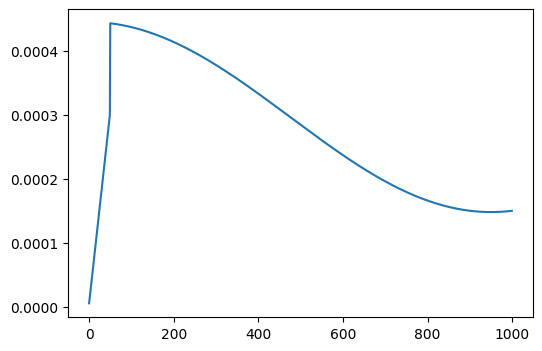

In [65]:
plt.figure(figsize=(6,4))
plt.plot(lrs)
plt.show()

### Accuracy for full val_data

In [62]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

correct, total = 0, 0
for xb, yb in val_data:
    logits = cnn(xb)
    preds = torch.argmax(logits, dim=-1)
    correct += (preds == yb).sum().item()
    total += yb.size(0)

val_acc = correct / total
print(f"Validation accuracy: {val_acc:.4f}")


Validation accuracy: 0.8387


### Next cifar10 : build3_vgg.ipynb